# Pre trained word embeddings

source : https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py

This script loads pre-trained word embeddings (GloVe embeddings)
into a frozen Keras Embedding layer, and uses it to
train a text classification model on pubblications

GloVe embedding data can be found at:
http://nlp.stanford.edu/data/glove.6B.zip
(source page: http://nlp.stanford.edu/projects/glove/)

FastText embedding data can be found at:
https://fasttext.cc/docs/en/english-vectors.html

dict2vec embedding data can be found at:
https://github.com/tca19/dict2vec

In [1]:
from __future__ import print_function

import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant

cwd = os.getcwd()
BASE_DIR = r'D:\Users\Baptiste\Documents\Telecom_Saint-Etienne\FISE_3\PRI\Classification'
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B\glove.6B.100d.txt')
FASTTEXT_DIR = os.path.join(BASE_DIR, 'fasttext\wiki-news-300d-1M-subword.vec')
DICT2VEC_DIR = os.path.join(BASE_DIR, 'dict2vec\dict2vec-vectors-dim100.vec')
TEXT_DATA_DIR = os.path.join(cwd, 'training_data')
MAX_SEQUENCE_LENGTH = 500
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
NUMBER_OF_USED_METADATA = 3

Using TensorFlow backend.


In [2]:
def load(fname):
    embeddings_index = {}
    with open(fname, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index       
    

# Load embedding vector

first, build index mapping words in the embeddings set to their embedding vector

In [3]:
print('Indexing word vectors.')

#embeddings_index = load(GLOVE_DIR) #average results
#embeddings_index = load(FASTTEXT_DIR) #meh results
embeddings_index = load(DICT2VEC_DIR) #good results

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 132923 word vectors.


# Load the dataset

second, prepare text samples and their labels

data augmentation: https://github.com/airbnb/artificial-adversary

In [4]:
import bibtexparser
from bibtexparser.bparser import BibTexParser
from Adversary import Adversary

#with open('training_data/codebasedcryptocayrelnet.bib') as bibtex_file:
#    bib_database = bibtexparser.load(bibtex_file)

print('Processing text dataset')

#texts = []  # list of text samples
x_title = []
x_keywords = []
x_booktitle = []
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
gen = Adversary() # for data augmentation

#name = "Articles_divers"
#label_id = len(labels_index)
#labels_index[name] = label_id
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            fpath = os.path.join(path, fname)
            with open(fpath) as bibtex_file:
                parser = BibTexParser(interpolate_strings=False)

                bib_database = bibtexparser.load(bibtex_file, parser)
                for publi in bib_database.entries:
                    title = publi['title'].lower().replace("{}", "")
                    if "keywords" in  publi:
                        keywords = publi['keywords'].lower().replace("{}", "")
                    else:
                        keywords = ""
                    if "booktitle" in  publi:
                        booktitle = publi['booktitle'].lower().replace("{}", "")
                    else:
                        booktitle = ""
                    x_title.append(title)
                    x_keywords.append(keywords)
                    x_booktitle.append(booktitle)
                    labels.append(label_id)
                    # data augmentation
                    titleGen = []
                    keywordsGen = []
                    booktitleGen = []
                    titleGen = gen.generate([title],text_sample_rate=5.0, word_sample_rate=0.5,
                                            attacks={'synonym':1})
                    keywordsGen = gen.generate([keywords],text_sample_rate=5.0, word_sample_rate=0.5,
                                            attacks={'synonym':1})
                    booktitleGen = gen.generate([booktitle],text_sample_rate=5.0, word_sample_rate=0.5,
                                            attacks={'synonym':1})
                    x_title.append(titleGen[0][0])
                    x_keywords.append(keywordsGen[0][0])
                    x_booktitle.append(booktitleGen[0][0])
                    labels.append(label_id)
                    

# Classes
#name = "Articles_cryptographie"
#label_id = len(labels_index)
#labels_index[name] = label_id

#for publi in bib_database.entries:
#    title = publi['title'].lower().replace("{}", "")
#    texts.append(title)
#    labels.append(label_id)

print('Found %s texts.' % len(x_title))
#labels_index

Processing text dataset


Entry type thesis not standard. Not considered.


Found 760 texts.


In [5]:
titleGen

[('{the at-most k -deep determinant', ['synonym'], 0),
 ('{the at-most $k$-deep factor determinant', ['synonym'], 0),
 ('{the at-most $k$-deep -deep tree}', ['synonym'], 0),
 ('{the at-most $k$-deep factor factor', ['synonym'], 0),
 ('{the at-most k -deep tree}', ['synonym'], 0)]

In [6]:
print('Dataset length: ', len(x_title))
print(labels_index)
print("0:", labels.count(0))
print("1:", labels.count(1))

Dataset length:  760
{'Crypto': 0, 'Others': 1}
0: 566
1: 194


In [7]:
#texts
x_title

["security-related comments regarding {mceliece} 's public-key cryptosystem",
 "security-related comments concerning mceliece 's public-key cryptosystem",
 'a new efficient threshold ring signature scheme based on coding theory',
 'a new efficient threshold ring signature scheme based on coding theory',
 'a new zero-knowledge code based identification scheme with reduced\ncommunication',
 'a latest zero-knowledge encode based identification scheme with reduced communication',
 'susceptibility of digital signature schemes based on error-correcting\ncodes to universal forgery',
 'susceptibility of digital signature schemes based on error-correcting codes to universal forgery',
 'a digital signature scheme based on linear error-correcting block\ncodes',
 'a digital signature schemes based on linear error-correcting block codes',
 'security of {xinmei} digital signature scheme',
 'secure of {xinmei} digital signature scheme',
 'cryptanalysis of the {harn} and {wang} modification of the {xi

In [8]:
x_keywords

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',


In [9]:
x_booktitle

['',
 '',
 'post-quantum cryptography, second international workshop, pqcrypto\n2008,{l}ecture {n}otes {c}omputer {s}cience, {s}pringer',
 'post-quantum cryptography, third international workshop, pqcrypto 2008 l {c}omputer {s}cience, {s}pringer',
 'corr abs/1111.1644',
 'corr abs/1111.1644',
 'error control, cryptology, and speech compression. selected papers\nfrom the workshop on information protection, {l}ecture {n}otes {c}omputer\n{s}cience, {s}pringer',
 'errors control, cryptology, and speech compression. selected papers from the workshop on information protection, l ecture {c}omputer otes c',
 "josef pieprzyk and reihanah safavi-naini (editors). advances cryptology-asiacrypt\n'94. proceedings of the fourth international conference held at the\nuniversity of wollongong, wollongong, november 28-december 1, {l}ecture\n{n}otes {c}omputer {s}cience 917. {s}pringer",
 "josef pieprzyk and reihanah safavi-naini (editors). advances cryptology-asiacrypt '94. proceedings of the fourth inte

# Vectorization

finally, vectorize the text samples into a 2D integer tensor

In [10]:
data = []
# titles
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x_title)
sequences_title = tokenizer.texts_to_sequences(x_title)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data_title = pad_sequences(sequences_title, maxlen=MAX_SEQUENCE_LENGTH)

# keywords
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x_keywords)
sequences_keywords = tokenizer.texts_to_sequences(x_keywords)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data_keywords = pad_sequences(sequences_keywords, maxlen=MAX_SEQUENCE_LENGTH)

# booktitle
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x_booktitle)
sequences_booktitle = tokenizer.texts_to_sequences(x_booktitle)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data_booktitle = pad_sequences(sequences_booktitle, maxlen=MAX_SEQUENCE_LENGTH)

###

data.append(data_title)
data.append(data_keywords)
data.append(data_booktitle)

data = np.moveaxis(data,0,1)
data = np.reshape(data,[len(x_title),MAX_SEQUENCE_LENGTH*NUMBER_OF_USED_METADATA])

data = np.array(data)

labels_categorical = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels_categorical.shape)

Found 1362 unique tokens.
Found 835 unique tokens.
Found 732 unique tokens.
Shape of data tensor: (760, 1500)
Shape of label tensor: (760, 2)


# Split the dataset

split the data into a training set and a validation set

In [11]:
#indices = np.arange(data.shape[0])
#np.random.shuffle(indices)
#data = data[indices]
#labels = labels[indices]
#num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

#x_train = data[:-num_validation_samples]
#y_train = labels[:-num_validation_samples]
#x_val = data[-num_validation_samples:]
#y_val = labels[-num_validation_samples:]

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(data, labels_categorical, test_size=0.2, random_state=0)


In [12]:
print('Preparing embedding matrix.')
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH*NUMBER_OF_USED_METADATA,
                            trainable=False)

Preparing embedding matrix.


# Create training model

In [13]:
print('Create training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH*NUMBER_OF_USED_METADATA,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

Create training model.


In [14]:
print(*[bla.shape for bla in [x_train, x_val, y_train, y_val]], sep="\n")

(608, 1500)
(152, 1500)
(608, 2)
(152, 2)


In [15]:
y_train[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

# Train the model

In [16]:
import matplotlib.pyplot as plt

print('Training model')

history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_val, y_val))

Training model
Train on 608 samples, validate on 152 samples
Epoch 1/10
608/608 [==============================] - 4s 6ms/step - loss: 0.7541 - acc: 0.7500 - val_loss: 0.5750 - val_acc: 0.7237
Epoch 2/10
608/608 [==============================] - 0s 704us/step - loss: 0.4888 - acc: 0.7599 - val_loss: 0.6234 - val_acc: 0.7237
Epoch 3/10
608/608 [==============================] - 0s 695us/step - loss: 0.4370 - acc: 0.7697 - val_loss: 0.4056 - val_acc: 0.7763
Epoch 4/10
608/608 [==============================] - 0s 692us/step - loss: 0.4294 - acc: 0.7944 - val_loss: 0.4108 - val_acc: 0.7500
Epoch 5/10
608/608 [==============================] - 0s 692us/step - loss: 0.3034 - acc: 0.8651 - val_loss: 0.4070 - val_acc: 0.8750
Epoch 6/10
608/608 [==============================] - 0s 692us/step - loss: 0.2459 - acc: 0.9211 - val_loss: 0.3869 - val_acc: 0.7829
Epoch 7/10
608/608 [==============================] - 0s 692us/step - loss: 0.2134 - acc: 0.9145 - val_loss: 0.1954 - val_acc: 0.9342
Epo

# Plot the result

plot model


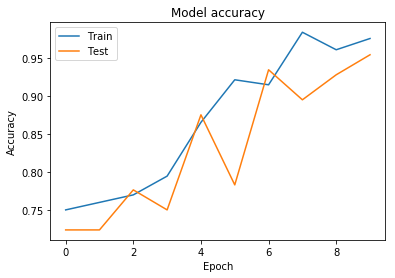

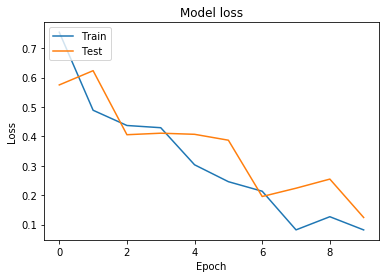

In [17]:
print('plot model')

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Save and load the model

In [18]:
# https://www.opencodez.com/python/text-classification-using-keras.htm
# Below code saves the model as well as tokenizer. We have to save our tokenizer because it is our vocabulary.
# The same tokenizer and vocabulary have to be used for accurate prediction.

# creates a HDF5 file
#model.save('model.h5') # uncomment this

In [19]:
from keras.models import load_model

# load our saved model
#model = load_model('model.h5') # uncomment this

# Display the confusion matrix

In [20]:
# Run classifier
y_pred = model.predict(x_val)

# convert output label: one hot encodeing -> integer encoding e.g.: [0, 0, 1] -> 2
y_pred_encoded = np.argmax(y_pred, -1)
y_val_encoded = np.argmax(y_val , -1)

In [29]:
y_val_encoded

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0],
      dtype=int64)

Confusion matrix, without normalization
[[110   0]
 [  7  35]]
Normalized confusion matrix
[[1.   0.  ]
 [0.17 0.83]]


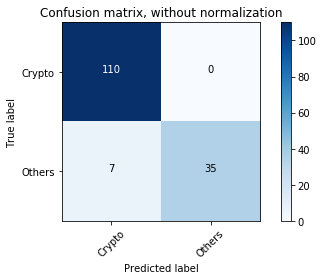

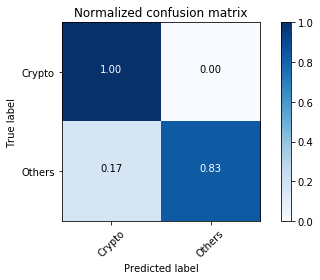

In [32]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val_encoded, y_pred_encoded)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels_index,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels_index, normalize=True,
                      title='Normalized confusion matrix')

plt.show()